<a href="https://colab.research.google.com/github/aaryandiwan/Influenza-Trend-Analysis-ML/blob/main/influenza_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Seasonal influenza using machine learning



This project analyzes seasonal influenza trends using the World Health Organization (WHO) influenza
surveillance dataset. Machine learning and time-series techniques are applied to estimate and analyze
long-term influenza activity patterns across multiple countries, with a focused case study on India.

##Introduction:

Seasonal influenza is a recurring public health challenge that affects populations worldwide every year.
Understanding long-term trends and seasonal patterns is critical for surveillance and preparedness.
This project applies machine learning techniques to WHO influenza surveillance data to analyze
historical trends and compare influenza activity across countries.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

## Data Source:

The dataset used in this project is the WHO Influenza Surveillance dataset, which contains weekly
laboratory surveillance records reported by multiple countries over several years.
The data represents reported influenza activity and not individual patient-level infections.


### here I am Loading and Filtering the Dataset (India Case Study)

The WHO Influenza Surveillance dataset is loaded from Google Drive into a pandas DataFrame.
For focused analysis, the dataset is filtered to include only records reported for India.
This subset is used to analyze country-specific influenza trends and to evaluate
machine learning models on India as a case study.

In [ ]:
# Replace 'your_folder_path_in_drive' with the actual path to your file in Google Drive
# For example: '/content/drive/MyDrive/MyData/Influenza_Dataset.csv'
file_path_in_drive = '/content/drive/MyDrive/Influenza_Dataset.csv' # Example path
df = pd.read_csv(file_path_in_drive)

# Filter India
df = df[df["COUNTRY_AREA_TERRITORY"] == "India"].copy()

print(f"DataFrame has {len(df)} rows after loading and filtering for India.")
df.head()

/tmp/ipython-input-2922072553.py:4: DtypeWarning: Columns (23,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path_in_drive)


DataFrame has 1459 rows after loading and filtering for India.


,WHO REGION,FLU SEASON,HEMISPHERE,ITZ,COUNTRY_CODE,COUNTRY_AREA_TERRITORY,ISO_WEEKSTARTDATE,ISO_YEAR,ISO_WEEK,MMWR_WEEKSTARTDATE,...,OTHERRESPVIRUS,OTHER_RESPVIRUS_DETAILS,LAB_RESULT_COMMENT,WCR_COMMENT,ISO2,ISOYW,MMWRYW,PSOURCE_SUBTYPE_INF,PSOURCE_PPOS_INF,PSOURCE_RSV
70472,SEAR,YR,NH,FLU_STH_ASIA,IND,India,09-08-2021,2021,32,08-08-2021,...,NaN,NaN,NaN,Samples tested for Influenza & SARS CoV-2,IN,202132,202132,NaN,NaN,NaN
70473,SEAR,YR,NH,FLU_STH_ASIA,IND,India,16-08-2021,2021,33,15-08-2021,...,NaN,NaN,NaN,Samples tested for Influenza & SARS CoV-2,IN,202133,202133,NaN,NaN,NaN
70474,SEAR,YR,NH,FLU_STH_ASIA,IND,India,23-08-2021,2021,34,22-08-2021,...,NaN,NaN,NaN,Samples tested for Influenza & SARS CoV-2,IN,202134,202134,NaN,NaN,NaN
70475,SEAR,YR,NH,FLU_STH_ASIA,IND,India,30-08-2021,2021,35,29-08-2021,...,NaN,NaN,NaN,Samples tested for Influenza & SARS CoV-2,IN,202135,202135,NaN,NaN,NaN
70476,SEAR,YR,NH,FLU_STH_ASIA,IND,India,06-09-2021,2021,36,05-09-2021,...,NaN,NaN,NaN,Samples tested for Influenza & SARS CoV-2,IN,202136,202136,NaN,NaN,NaN


## here I am Loading the WHO Influenza Surveillance Dataset

The complete WHO Influenza Surveillance dataset is loaded from Google Drive into a pandas DataFrame.
The `low_memory=False` parameter is used to ensure robust parsing of the large dataset
and to prevent mixed data type issues during import.
After loading, the total number of rows and columns is printed to verify
that the full global dataset has been successfully imported.

In [ ]:
import pandas as pd
import numpy as np

# Use the correct path to the file in Google Drive
file_path_in_drive = '/content/drive/MyDrive/Influenza_Dataset.csv' # Ensure this path is correct for your file
df = pd.read_csv(file_path_in_drive, low_memory=False) # Added low_memory=False for robust parsing

print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])

Total rows: 180318
Total columns: 53


## Data Cleaning and Preprocessing:

Data preprocessing was performed to ensure consistency and reliability.
Missing categorical values were filled using mode imputation, while missing numerical values were
handled using year-wise median imputation following WHO-style data handling practices.


### Handling Missing Values

Missing values in the dataset are handled using a structured and WHO-compliant approach.
Categorical columns are filled using the mode (most frequent value) to preserve consistency,
while numerical columns are imputed using the median calculated on a year-wise basis.
Year-wise median imputation helps retain temporal trends and reduces the influence of outliers,
making the dataset suitable for time-series and machine learning analysis.


In [ ]:
# Fill categorical columns
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical columns year-wise median
num_cols = df.select_dtypes(include="number").columns
df[num_cols] = df.groupby("ISO_YEAR")[num_cols].transform(
    lambda x: x.fillna(x.median())
)

## Calculation of Influenza Positivity Rate

The influenza positivity rate is calculated as the proportion of laboratory-confirmed
Influenza A and B cases relative to the total number of specimens processed.
This metric is widely used in public health surveillance as it provides a normalized
measure of influenza activity that is independent of testing volume.
Infinite values resulting from division by zero are safely handled and replaced with zero.
The average positivity rate is then computed for each country to enable cross-country
comparison of influenza activity levels.


In [ ]:
import numpy as np
# Calculate positivity rate
df["positivity_rate"] = (df["INF_A"] + df["INF_B"]) / df["SPEC_PROCESSED_NB"]
df["positivity_rate"] = df["positivity_rate"].replace([np.inf, -np.inf], 0)

# Calculate average positivity rate per country
country_positivity_rate = df.groupby('COUNTRY_AREA_TERRITORY')['positivity_rate'].mean().sort_values(ascending=False).reset_index()

print("Average Positivity Rate by Country (Top 10):\n", country_positivity_rate.head(10))

Average Positivity Rate by Country (Top 10):
     COUNTRY_AREA_TERRITORY  positivity_rate
0                    Japan         5.904072
1  United Kingdom, England         4.617076
2     China, Hong Kong SAR         3.122802
3                  Belgium         2.449537
4              Switzerland         2.265733
5                  Lesotho         1.780942
6                    Sudan         1.375236
7                 Anguilla         1.100000
8         Saint Barthélemy         1.042553
9                  Finland         0.981533


## Country-wise Analysis of Influenza Positivity Rate

The influenza positivity rate is computed by dividing the total number of
laboratory-confirmed Influenza A and B cases by the total number of specimens processed.
This rate provides a standardized measure of influenza activity that accounts for
differences in testing volume across countries.
The average positivity rate is then calculated for each country to enable
meaningful cross-country comparison and to identify regions with relatively higher


In [ ]:
df["positivity_rate"] = (df["INF_A"] + df["INF_B"]) / df["SPEC_PROCESSED_NB"]
df["positivity_rate"] = df["positivity_rate"].replace([np.inf, -np.inf], 0)

# Calculate average positivity rate per country
country_positivity_rate = df.groupby('COUNTRY_AREA_TERRITORY')['positivity_rate'].mean().sort_values(ascending=False).reset_index()

print("Average Positivity Rate by Country (Top 10):\n", country_positivity_rate.head(10))

Average Positivity Rate by Country (Top 10):
     COUNTRY_AREA_TERRITORY  positivity_rate
0                    Japan         5.904072
1  United Kingdom, England         4.617076
2     China, Hong Kong SAR         3.122802
3                  Belgium         2.449537
4              Switzerland         2.265733
5                  Lesotho         1.780942
6                    Sudan         1.375236
7                 Anguilla         1.100000
8         Saint Barthélemy         1.042553
9                  Finland         0.981533


## Comparison of Average Influenza Positivity Rate Across Countries

This bar plot visualizes the average influenza positivity rate for the top reporting
countries. By focusing on the highest-ranking countries, the visualization highlights
meaningful differences in influenza activity levels while maintaining clarity.
Using positivity rate as the metric ensures a normalized comparison that accounts for
variations in testing intensity across countries.


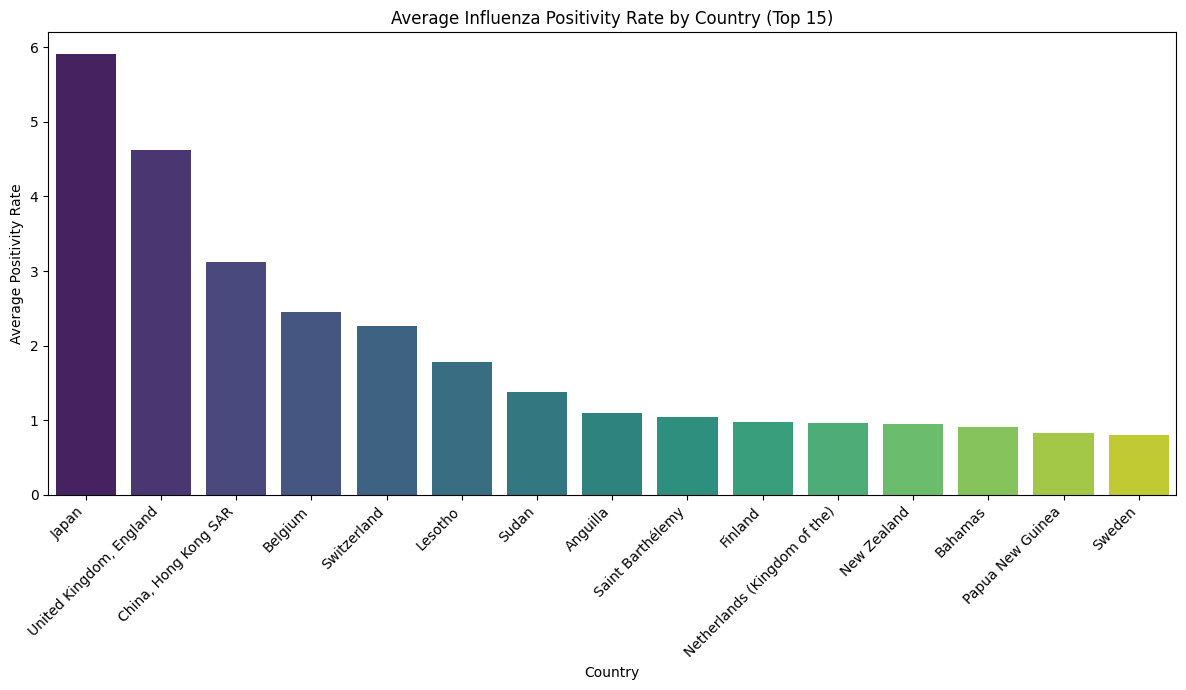

In [ ]:
# Plot average positivity rate for top countries (or all if too many)
import matplotlib.pyplot as plt
import seaborn as sns

if 'country_positivity_rate' in locals():
    plt.figure(figsize=(12, 7))
    sns.barplot(x='COUNTRY_AREA_TERRITORY', y='positivity_rate', data=country_positivity_rate.head(15), hue='COUNTRY_AREA_TERRITORY', legend=False, palette='viridis')
    plt.title('Average Influenza Positivity Rate by Country (Top 15)')
    plt.xlabel('Country')
    plt.ylabel('Average Positivity Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Error: country_positivity_rate is not defined. Please ensure the preceding cell was executed successfully.")

## Temporal Trend of Influenza Positivity Rate

This plot illustrates the change in influenza positivity rate over time using
weekly surveillance data. The ISO week start date is converted to a datetime
format to enable accurate time-series visualization.
Tracking positivity rate over time provides insight into changes in influenza
transmission intensity independent of testing volume, making it a key indicator
for public health surveillance and trend analysis.


/tmp/ipython-input-1789708399.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['ISO_WEEKSTARTDATE'] = pd.to_datetime(df['ISO_WEEKSTARTDATE'])


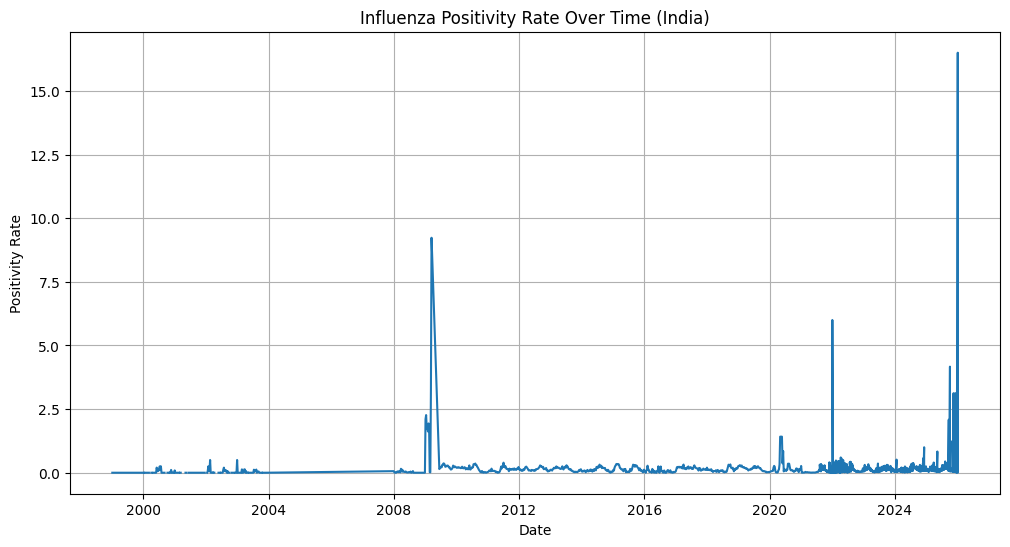

In [ ]:
# Ensure ISO_WEEKSTARTDATE is in datetime format
df['ISO_WEEKSTARTDATE'] = pd.to_datetime(df['ISO_WEEKSTARTDATE'])

plt.figure(figsize=(12, 6))
plt.plot(df['ISO_WEEKSTARTDATE'], df['positivity_rate'])
plt.title('Influenza Positivity Rate Over Time (India)')
plt.xlabel('Date')
plt.ylabel('Positivity Rate')
plt.grid(True)
plt.show()

In [ ]:
df["positivity_rate"] = (df["INF_A"] + df["INF_B"]) / df["SPEC_PROCESSED_NB"]
df["positivity_rate"] = df["positivity_rate"].replace([np.inf, -np.inf], 0)

## Feature Engineering for Time-Series Modeling

To prepare the dataset for machine learning, the data is first sorted by country,
year, and week to preserve temporal order. A month-level feature is derived from
weekly data to capture broader seasonal patterns.
The target variable is defined as the total reported influenza cases, and time-series
features such as lag values and rolling averages are created on a country-wise basis.
These features enable the models to learn historical dependencies and seasonal trends
in influenza activity across different countries.


In [ ]:
df = df.sort_values(["COUNTRY_AREA_TERRITORY", "ISO_YEAR", "ISO_WEEK"])

df["Month"] = ((df["ISO_WEEK"] - 1) // 4) + 1

df["lag_1"] = df.groupby("COUNTRY_AREA_TERRITORY")["Target"].shift(1)
df["lag_2"] = df.groupby("COUNTRY_AREA_TERRITORY")["Target"].shift(2)
df["lag_3"] = df.groupby("COUNTRY_AREA_TERRITORY")["Target"].shift(3) # Added lag_3
df["roll_3"] = df.groupby("COUNTRY_AREA_TERRITORY")["Target"].rolling(3).mean().reset_index(0, drop=True)
df["roll_5"] = df.groupby("COUNTRY_AREA_TERRITORY")["Target"].rolling(5).mean().reset_index(0, drop=True) # Added roll_5

# Removed df.dropna(inplace=True) here. NaNs will be handled in the next step (goB5Yn7mZoE8).

## Aggregation of Year-wise Influenza Trends for Selected Countries

For comparative trend analysis, the dataset is filtered to include a selected list
of high-reporting countries. Influenza activity is then aggregated on a yearly basis
for each country by summing the target variable.
This aggregation enables clear visualization and comparison of long-term influenza
trends across different countries while reducing short-term weekly variability.


In [ ]:
trend_df = df[df["COUNTRY_AREA_TERRITORY"].isin(top_countries_list)]

country_yearly = (
    trend_df
    .groupby(["COUNTRY_AREA_TERRITORY", "ISO_YEAR"])["Target"]
    .sum()
    .reset_index()
)

## Visualization of Global Influenza Trend Predictions

This plot compares the actual influenza activity with predictions generated by
different machine learning models using the global WHO influenza dataset.
Conditional checks are included to ensure that all required variables and model
outputs have been properly generated before visualization, preventing runtime
errors and improving notebook robustness.
The visualization provides an intuitive assessment of how well the models capture
overall influenza trends across countries.


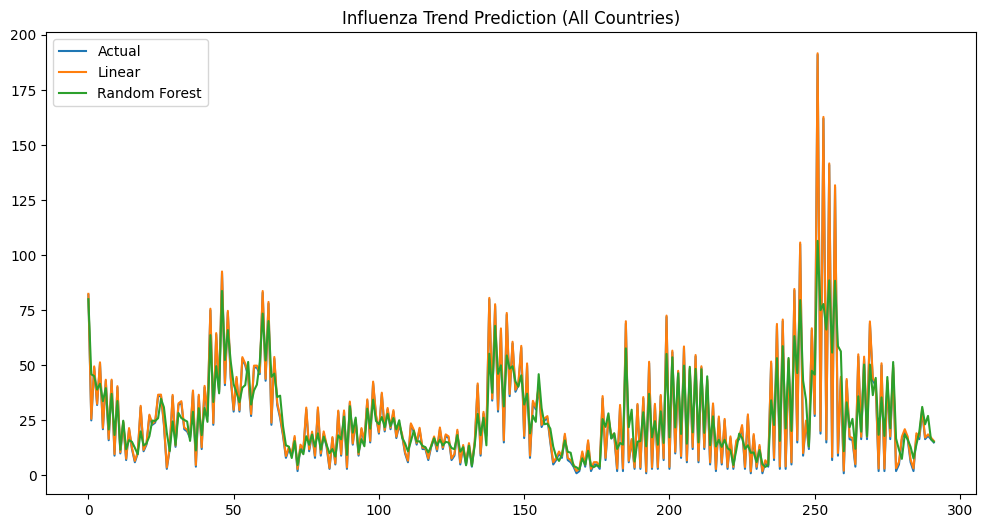

In [ ]:
import matplotlib.pyplot as plt

# Ensure y_test, lr_pred, and rf_pred are defined from previous cells.
# If you see a NameError, please re-run cells that define df, X_train/test, y_train/test, and model predictions.
# Specifically, ensure cell 916b55b7 (data loading) and subsequent preprocessing and model training cells (goB5Yn7mZoE8, vsin0rI_Zvxg, zdJqX_8EaweD) have been executed.

if 'y_test' in locals() and 'lr_pred' in locals() and 'rf_pred' in locals():
    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label="Actual")
    plt.plot(lr_pred, label="Linear")
    plt.plot(rf_pred, label="Random Forest")
    plt.legend()
    plt.title("Influenza Trend Prediction (All Countries)") # Changed title as we're aiming for all countries
    plt.show()
else:
    print("Error: y_test, lr_pred, or rf_pred are not defined. Please ensure all preceding data loading, preprocessing, and model training cells have been run successfully, starting with ensuring the \"Influenza_Dataset.csv\" file is correctly loaded in cell 916b55b7.")

## Comparison of Actual and Predicted Influenza Trends

This line plot compares the actual influenza activity with predictions generated
by different machine learning models. Visual comparison helps evaluate how well
each model captures overall trends and seasonal fluctuations.
Such plots are particularly useful in time-series analysis, as they provide
intuitive insight into model performance beyond numerical error metrics.


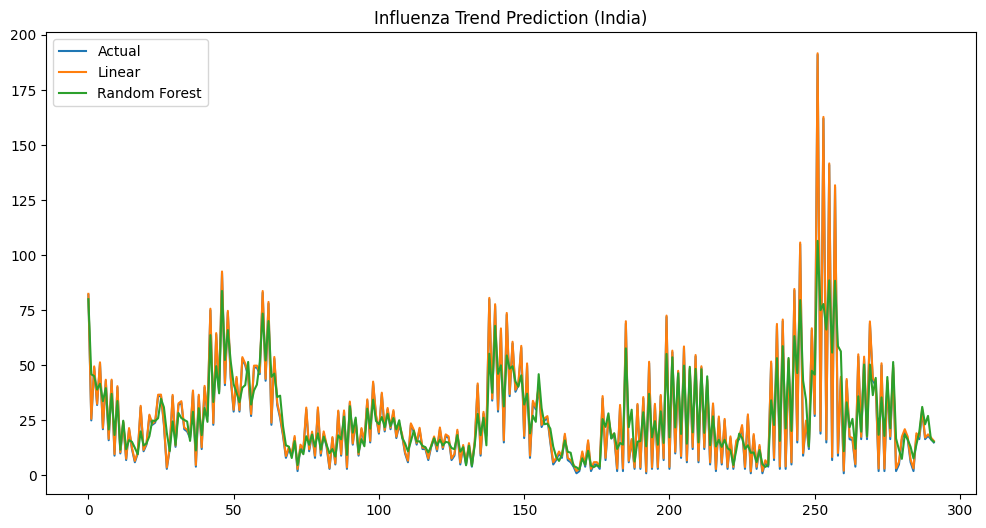

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual")
plt.plot(lr_pred, label="Linear")
plt.plot(rf_pred, label="Random Forest")
plt.legend()
plt.title("Influenza Trend Prediction (India)")
plt.show()


## Time-Series Comparison of Influenza Trends in Top Reporting Countries

This line plot visualizes influenza activity trends over time for the top five
reporting countries. By plotting weekly influenza activity on a common time axis,
the visualization highlights similarities and differences in seasonal patterns,
trend magnitude, and temporal fluctuations across countries.
This comparison helps illustrate how influenza dynamics vary geographically
while sharing common seasonal characteristics.


In [ ]:
top_5_countries = df.groupby('COUNTRY_AREA_TERRITORY')['Target'].sum().sort_values(ascending=False).head(5)
print("Top 5 Countries by Total Influenza Cases:")
print(top_5_countries)

Top 5 Countries by Total Influenza Cases:
COUNTRY_AREA_TERRITORY
United States of America    3529808.0
China                       1294736.0
Canada                       887268.0
United Kingdom, England      444063.0
France                       345523.0
Name: Target, dtype: float64


## Country-wise Trend Comparison

Influenza trends were compared across selected high-reporting countries including
the United States, China, India, the United Kingdom, and Australia.
Normalized trends were used to enable fair comparison across countries
with different reporting volumes.


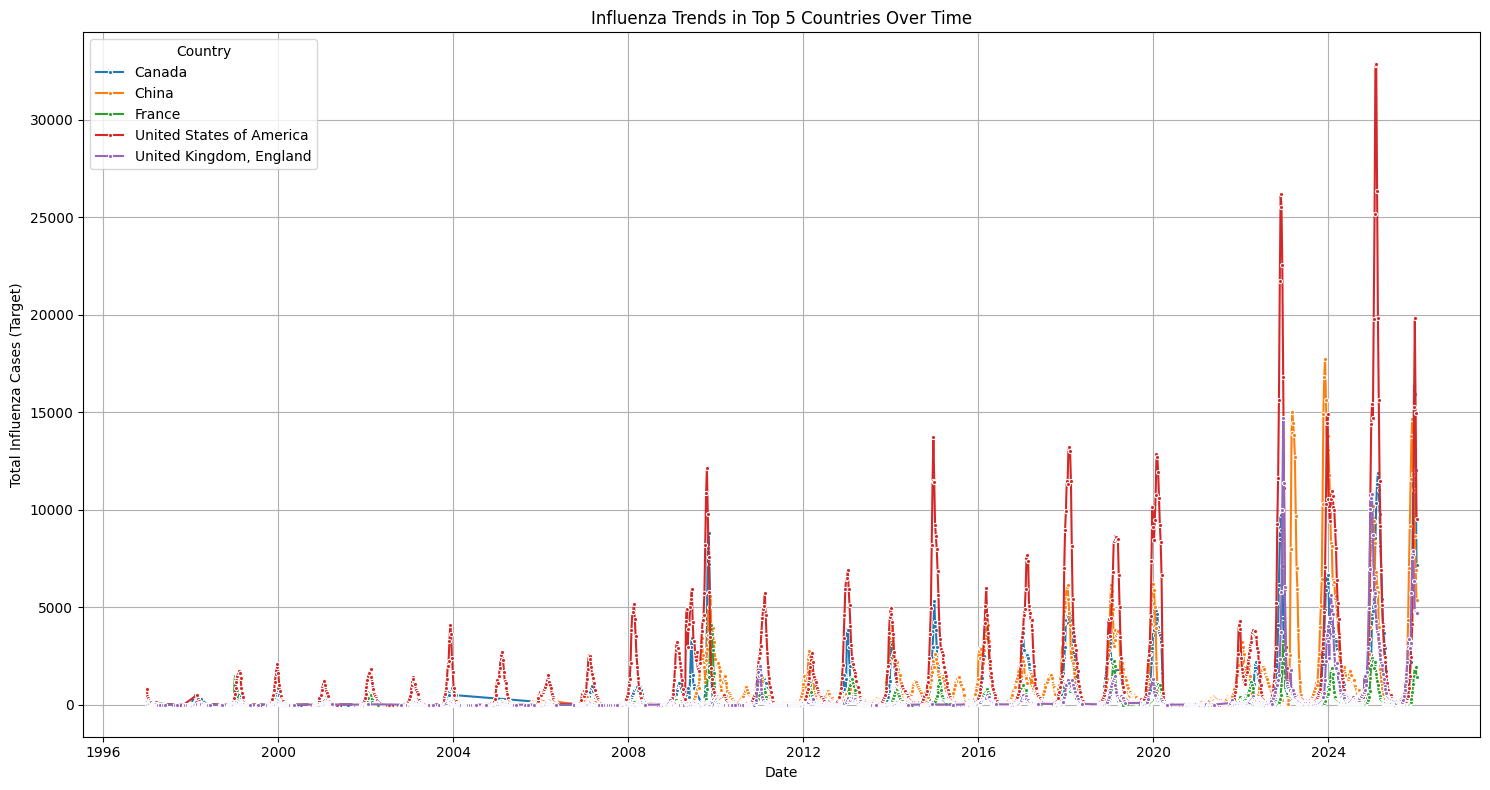

In [ ]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_top_5, x='ISO_WEEKSTARTDATE', y='Target', hue='COUNTRY_AREA_TERRITORY', marker='.', errorbar=None)
plt.title('Influenza Trends in Top 5 Countries Over Time')
plt.xlabel('Date')
plt.ylabel('Total Influenza Cases (Target)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()

## Year-wise Comparison of Influenza Trends Across Top Countries

This line plot compares annual influenza activity trends across selected
high-reporting countries. By aggregating influenza cases on a yearly basis,
the visualization highlights long-term trend differences and similarities
between countries while reducing short-term weekly fluctuations.
Such comparisons help understand how influenza burden and reporting patterns
vary across regions over time.


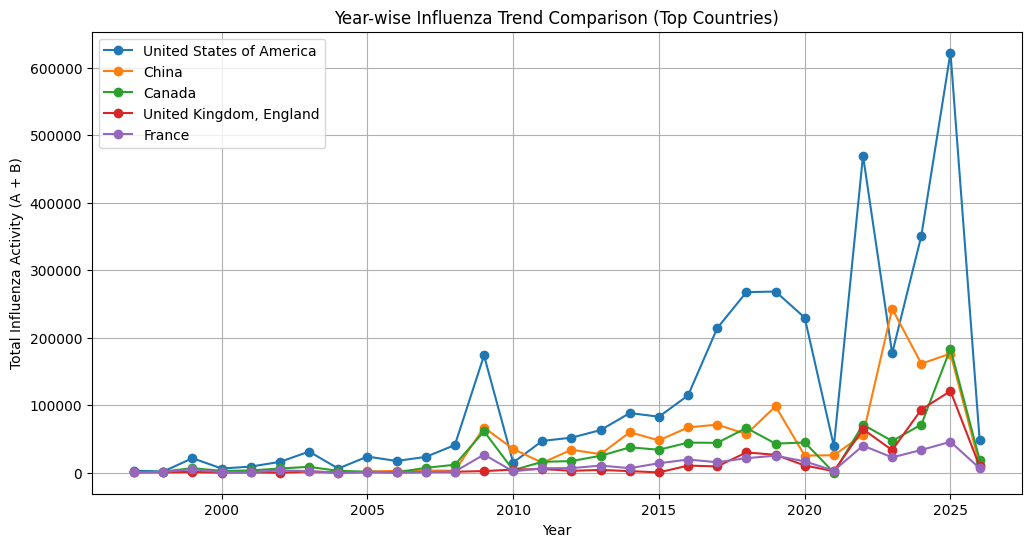

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for country in top_countries_list: # Corrected from popular_countries
    subset = country_yearly[country_yearly["COUNTRY_AREA_TERRITORY"] == country]
    plt.plot(subset["ISO_YEAR"], subset["Target"], marker="o", label=country) # Corrected from YEAR to ISO_YEAR

plt.title("Year-wise Influenza Trend Comparison (Top Countries)")
plt.xlabel("Year")
plt.ylabel("Total Influenza Activity (A + B)")
plt.legend()
plt.grid(True)
plt.show()

## Comparison of Influenza A and Influenza B Trends

This line plot compares year-wise aggregated trends of Influenza A and Influenza B
cases. By visualizing both virus types together, the analysis highlights differences
in dominance, variability, and long-term behavior between the two strains.
Such comparisons are important for understanding strain-specific influenza dynamics
and for supporting public health surveillance and preparedness.


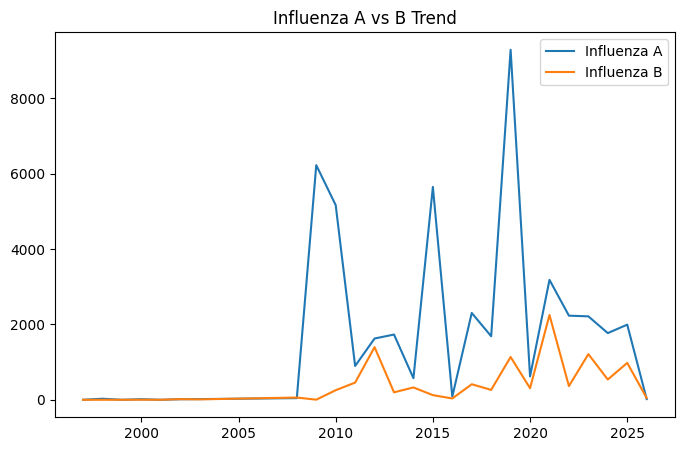

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df.groupby("ISO_YEAR")["INF_A"].sum(), label="Influenza A")
plt.plot(df.groupby("ISO_YEAR")["INF_B"].sum(), label="Influenza B")
plt.legend()
plt.title("Influenza A vs B Trend")
plt.show()

## Comparative Analysis of Year-wise Influenza Trends in Top Countries

This visualization presents a comparative analysis of annual influenza activity
across selected top-reporting countries. By plotting year-wise aggregated influenza
counts, the chart highlights long-term trends, relative differences in influenza
burden, and similarities in temporal behavior across countries.
This analysis supports cross-country comparison of influenza dynamics using
WHO surv


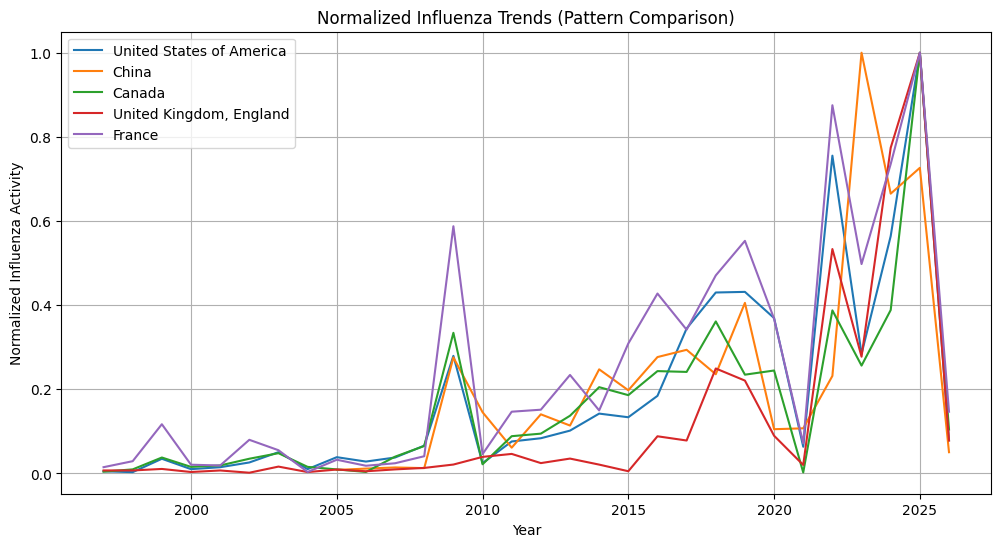

In [ ]:
plt.figure(figsize=(12,6))

for country in top_countries_list:
    subset = country_yearly[country_yearly["COUNTRY_AREA_TERRITORY"] == country]
    plt.plot(subset["ISO_YEAR"], subset["Normalized_Target"], label=country)

plt.title("Normalized Influenza Trends (Pattern Comparison)")
plt.xlabel("Year")
plt.ylabel("Normalized Influenza Activity")
plt.legend()
plt.grid()
plt.show()

In [ ]:
trend_df = df[df["COUNTRY_AREA_TERRITORY"].isin(top_countries_list)]

country_yearly = (
    trend_df
    .groupby(["COUNTRY_AREA_TERRITORY", "ISO_YEAR"])["Target"]
    .sum()
    .reset_index()
)

In [ ]:
country_yearly["Normalized_Target"] = (
    country_yearly
    .groupby("COUNTRY_AREA_TERRITORY")["Target"]
    .transform(lambda x: x / x.max())
)


## Year-wise Influenza Activity Trend

This visualization presents the year-wise aggregated influenza activity based on
the target variable. By summing influenza cases for each year, the plot highlights
long-term trends and changes in influenza burden over time.
Such analysis helps identify periods of increased or decreased influenza activity
and provides important context for understanding temporal patterns in surveillance data.


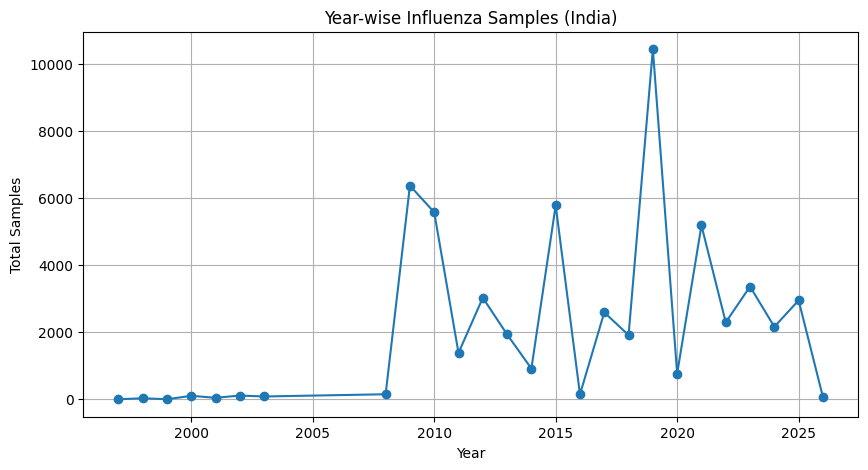

In [ ]:
yearly = df.groupby("ISO_YEAR")["Target"].sum()

plt.figure(figsize=(10,5))
yearly.plot(marker="o")
plt.title("Year-wise Influenza Samples (India)")
plt.xlabel("Year")
plt.ylabel("Total Samples")
plt.grid()
plt.show()

## Analysis of Weekly Influenza Seasonality

This plot illustrates the average influenza activity for each epidemiological week
across all years. By averaging weekly values, the visualization reveals recurring
seasonal patterns in influenza activity.
Such seasonality analysis is essential for understanding periodic peaks and troughs
in influenza transmission and supports the use of time-series modeling approaches.


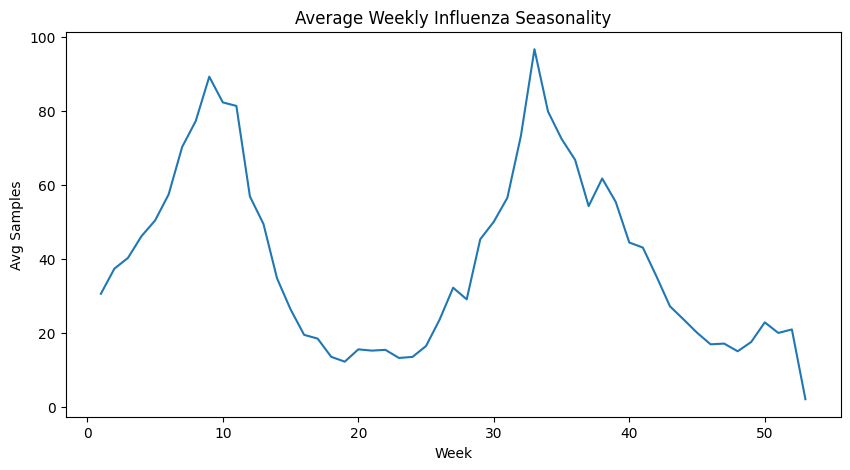

In [ ]:
weekly_avg = df.groupby("ISO_WEEK")["Target"].mean()

plt.figure(figsize=(10,5))
weekly_avg.plot()
plt.title("Average Weekly Influenza Seasonality")
plt.xlabel("Week")
plt.ylabel("Avg Samples")
plt.show()

## Seasonal Decomposition of Influenza Time Series

Seasonal decomposition is applied to the influenza time series to separate it into
trend, seasonal, and residual components. Missing values are filled using the median
to ensure stable decomposition.
This analysis helps identify long-term trends, recurring seasonal patterns, and
irregular fluctuations in influenza activity, providing deeper insight into


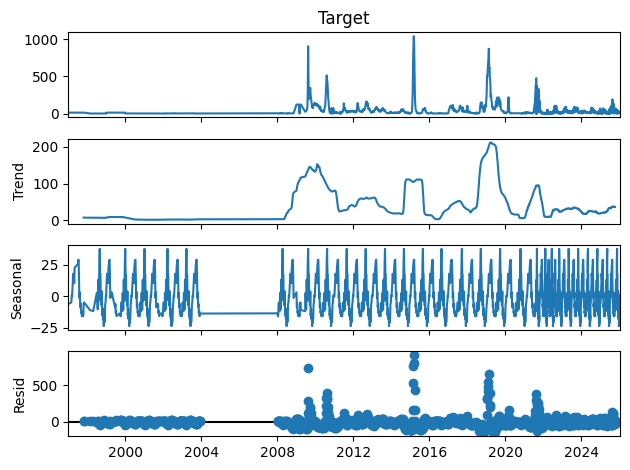

In [ ]:
decomp = seasonal_decompose(ts.fillna(ts.median()), model="additive", period=52)
decomp.plot()
plt.show()

##Exploratory Data Analysis (EDA)

Exploratory data analysis was conducted to understand the distribution, seasonality,
and long-term trends of influenza activity. Visualizations were used to identify
year-wise patterns, weekly seasonality, and the impact of global events such as COVID-19.


## Impact of COVID-19 on Influenza Activity Across Countries

This bar plot compares average influenza activity across countries during
three distinct periods: pre-COVID, COVID, and post-COVID.
By segmenting the timeline, the visualization highlights the significant
reduction in influenza activity during the COVID period, likely due to
public health interventio


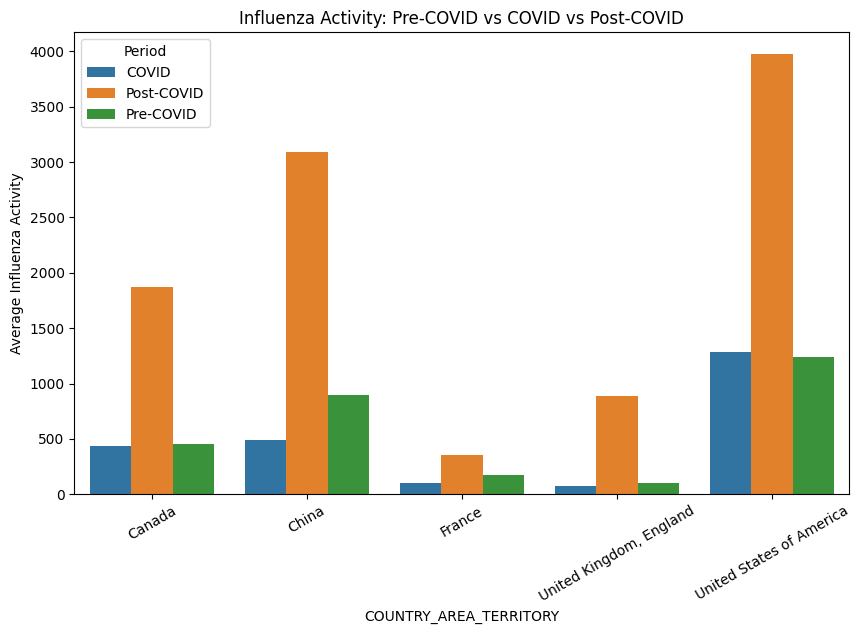

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=period_analysis,
    x="COUNTRY_AREA_TERRITORY",
    y="Target",
    hue="Period"
)

plt.title("Influenza Activity: Pre-COVID vs COVID vs Post-COVID")
plt.ylabel("Average Influenza Activity")
plt.xticks(rotation=30)
plt.show()


## Period-wise Analysis of Influenza Activity (Pre-COVID, COVID, Post-COVID)

The dataset is segmented into three time periods based on the year of observation:
pre-COVID, COVID, and post-COVID. This classification enables quantitative comparison
of average influenza activity across these phases.
The analysis highlights the impact of COVID-19 on influenza reporting and transmission,
with a noticeable decline during the COVID period, followed by gradual recovery
in the post-COVID phase.


In [ ]:
trend_df.loc[:, "Period"] = np.where(
    trend_df["ISO_YEAR"] < 2020, "Pre-COVID",
    np.where(trend_df["ISO_YEAR"] <= 2021, "COVID", "Post-COVID")
)

period_analysis = (
    trend_df
    .groupby(["COUNTRY_AREA_TERRITORY", "Period"])["Target"]
    .mean()
    .reset_index()
)

Period
COVID         47.512000
Post-COVID    24.040000
Pre-COVID     49.248481
Name: Target, dtype: float64


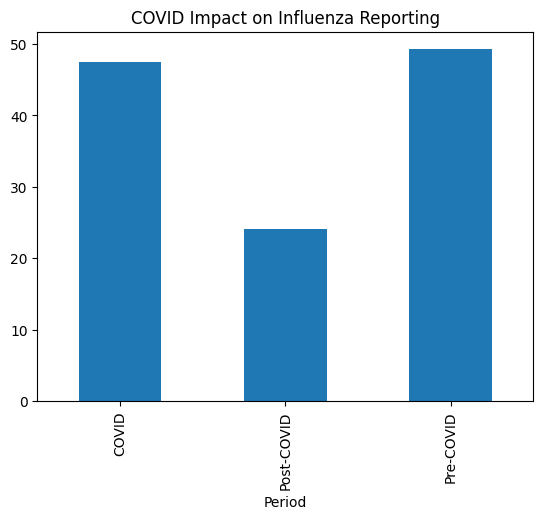

In [ ]:
df["Period"] = np.where(df["ISO_YEAR"] < 2020, "Pre-COVID",
                  np.where(df["ISO_YEAR"] <= 2021, "COVID", "Post-COVID"))

covid_analysis = df.groupby("Period")["Target"].mean()
print(covid_analysis)

covid_analysis.plot(kind="bar", title="COVID Impact on Influenza Reporting")
plt.show()

## Heatmap Visualization of Influenza Activity Across Countries

A heatmap is used to visualize year-wise influenza activity across selected countries.
This representation allows easy identification of temporal patterns, intensity variations,
and cross-country differences in influenza trends.
Color gradients help highlight periods of high and low influenza activity,
making the comparison of long-term trends across countries more intuitive.


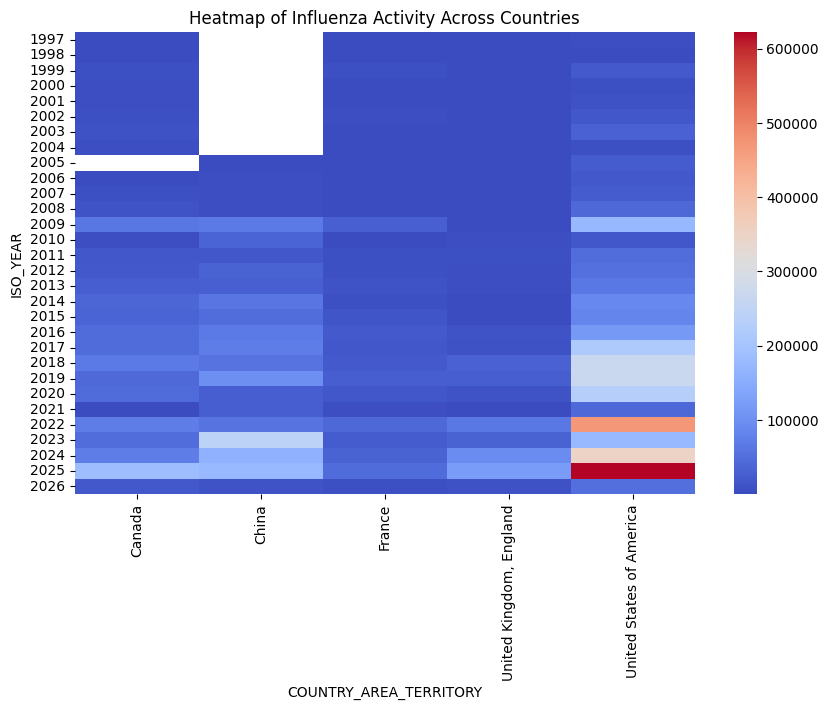

In [ ]:
pivot = country_yearly.pivot(
    index="ISO_YEAR",
    columns="COUNTRY_AREA_TERRITORY",
    values="Target"
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm")
plt.title("Heatmap of Influenza Activity Across Countries")
plt.show()

## Handling Missing Values Using WHO-Style Imputation

Missing values in the dataset are handled using a structured and epidemiologically
appropriate approach. Categorical variables are imputed using the mode (most frequent
value) to maintain categorical consistency.
Numerical variables are imputed using year-wise median values to preserve temporal
trends and reduce the impact of outliers. This method ensures that the integrity of
seasonal and long-term influenza patterns is retained for subsequent analysis
and machine learning modeling.


In [ ]:
# Fill categorical columns
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical columns year-wise median
num_cols = df.select_dtypes(include="number").columns
df[num_cols] = df.groupby("ISO_YEAR")[num_cols].transform(
    lambda x: x.fillna(x.median())
)

## Preparing Data for Machine Learning and Time-Based Train–Test Split

Relevant time-series features are selected to train the machine learning model,
including temporal variables, lag features, and rolling statistics.
The dataset is split into training and testing sets using a time-based approach,
where earlier observations are used for training and more recent observations
are reserved for testing. This method prevents data leakage and is appropriate
for time-series and surveillance data analysis.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

features = ["ISO_YEAR", "ISO_WEEK", "Month", "lag_1", "lag_2", "roll_3"]
X = df[features]
y = df["Target"]

split = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

## Imputation of Missing Values

To ensure data quality and consistency, missing values in the dataset are handled
using a structured imputation strategy. Categorical variables are filled using
their most frequent value (mode) to preserve categorical integrity.
Numerical variables are imputed using the median calculated on a year-wise basis,
which helps maintain temporal trends and minimizes the influence of extreme values.
This preprocessing step prepares the dataset for reliable exploratory analysis
and machine learning modeling.


In [ ]:
# Fill categorical columns
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical columns year-wise median
num_cols = df.select_dtypes(include="number").columns
df[num_cols] = df.groupby("ISO_YEAR")[num_cols].transform(
    lambda x: x.fillna(x.median())
)

In [ ]:
print(df.columns)

Index(['WHO REGION', 'FLU SEASON', 'HEMISPHERE', 'ITZ', 'COUNTRY_CODE',
       'COUNTRY_AREA_TERRITORY', 'ISO_WEEKSTARTDATE', 'ISO_YEAR', 'ISO_WEEK',
       'MMWR_WEEKSTARTDATE', 'MMWR_YEAR', 'MMWR_WEEK', 'ORIGIN_SOURCE',
       'SPEC_PROCESSED_NB', 'SPEC_RECEIVED_NB', 'AH1N12009', 'AH1', 'AH3',
       'AH5', 'AH7N9', 'ANOTSUBTYPED', 'ANOTSUBTYPABLE', 'AOTHER_SUBTYPE',
       'AOTHER_SUBTYPE_DETAILS', 'INF_A', 'BVIC_2DEL', 'BVIC_3DEL',
       'BVIC_NODEL', 'BVIC_DELUNK', 'BYAM', 'BNOTDETERMINED', 'INF_B',
       'INF_ALL', 'INF_NEGATIVE', 'ILI_ACTIVITY', 'ADENO', 'BOCA',
       'HUMAN_CORONA', 'METAPNEUMO', 'PARAINFLUENZA', 'RHINO', 'RSV_PROCESSED',
       'RSV', 'OTHERRESPVIRUS', 'OTHER_RESPVIRUS_DETAILS',
       'LAB_RESULT_COMMENT', 'WCR_COMMENT', 'ISO2', 'ISOYW', 'MMWRYW',
       'PSOURCE_SUBTYPE_INF', 'PSOURCE_PPOS_INF', 'PSOURCE_RSV', 'Month',
       'Target', 'lag_1', 'lag_2', 'lag_3', 'roll_3', 'roll_5'],
      dtype='object')


## Training and Evaluation of the Random Forest Model

A Random Forest Regressor is trained using the selected time-series features to
model influenza activity trends. The model parameters are chosen to balance
model complexity and generalization.
Model performance is evaluated on the test dataset using Mean Absolute Error (MAE)
and Root Mean Squared Error (RMSE), which quantify the accuracy of trend estimation
while penalizing large prediction errors.


In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Global MAE:", mean_absolute_error(y_test, rf_pred))
print("Global RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))

Global MAE: 49.50884263143824
Global RMSE: 731.931048089099


## Feature Importance Analysis Using Random Forest

This visualization displays the relative importance of input features as learned
by the Random Forest model. Feature importance scores indicate how much each
variable contributes to reducing prediction error.
The analysis helps interpret model behavior by identifying which temporal features,
such as lag values and rolling statistics, play the most significant role in
estimating influenza activity trends.


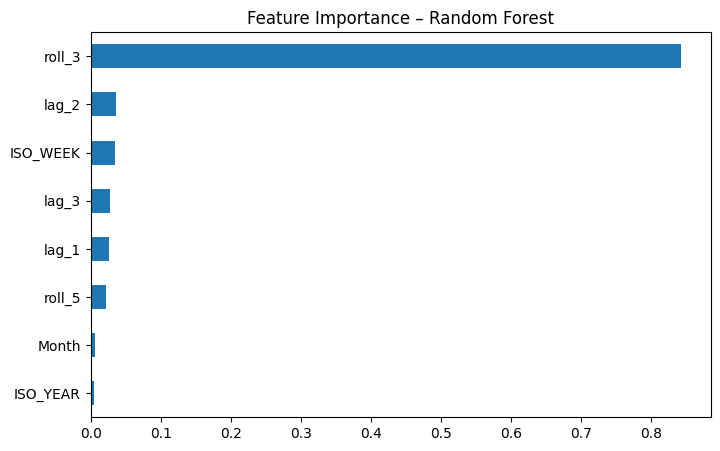

In [ ]:
importance = pd.Series(rf.feature_importances_, index=features)
importance.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance – Random Forest")
plt.show()


## Residual Analysis of the Random Forest Model

This plot visualizes the distribution of residuals (prediction errors) from the
Random Forest model. Analyzing residuals helps assess whether the model errors
are randomly distributed around zero, which is an important assumption for
reliable model performance.
A near-symmetric distribution of residuals indicates that the model does not
exhibit strong systematic bias in its predictions.


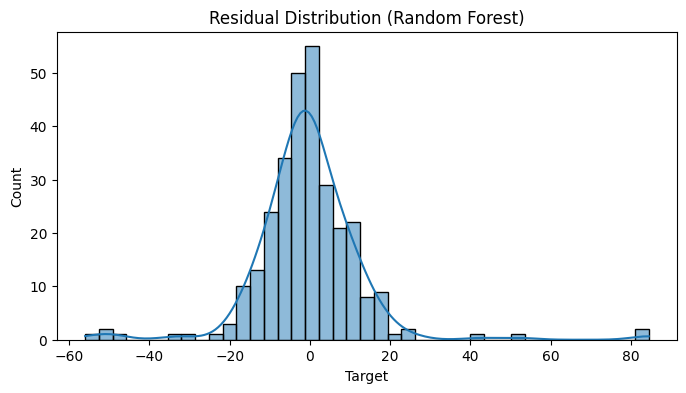

In [ ]:
residuals = y_test - rf_pred

plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Random Forest)")
plt.show()



## Baseline Modeling Using Linear Regression

Linear Regression is used as a baseline model to estimate influenza activity trends
based on the engineered time-series features. As a simple and interpretable model,
it provides a reference point for evaluating the performance of more complex models.
Model performance is assessed using Mean Absolute Error (MAE) and Root Mean Squared
Error (RMSE), allowing direct comparison with advanced machine learning approaches.


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, lr_pred))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))

Linear Regression MAE: 0.814536711256552
Linear Regression RMSE: 0.8372892771257078


## Comparison of Machine Learning Model Performance

This table summarizes the performance of different machine learning models used
in the study. Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are reported
to compare how accurately each model estimates influenza activity trends.
The comparison highlights the improvement achieved by more advanced models
over the baseline linear regression approach.


In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, rf_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred))
    ]
})

results


,Model,MAE,RMSE
0,Linear Regression,0.814537,0.837289
1,Random Forest,8.260047,13.345050


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results)

https://docs.google.com/spreadsheets/d/1Do21cvxOayZr3Y-7sPd9pIFx4UK3Fz87Ub0eY_I6ei8/edit#gid=0


## Visual Comparison of Model Performance (MAE and RMSE)

This visualization compares the performance of different machine learning models
using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).
By presenting both metrics side by side, the plot provides a clear and intuitive
comparison of model accuracy and error magnitude.
Such visual evaluation complements numerical results and helps identify models
that achieve better trade-offs between bias and variance in influenza trend estimation.


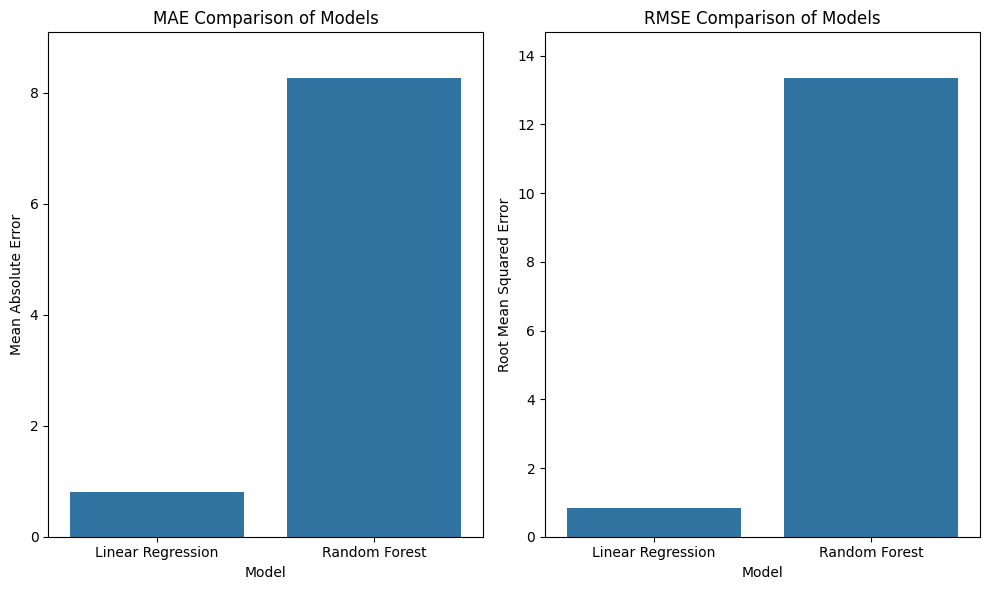

In [ ]:
plt.figure(figsize=(10, 6))

# MAE Plot
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.barplot(x='Model', y='MAE', data=results)
plt.title('MAE Comparison of Models')
plt.ylabel('Mean Absolute Error')
plt.ylim(0, results['MAE'].max() * 1.1) # Set y-limit slightly above max MAE for better visual

# RMSE Plot
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('RMSE Comparison of Models')
plt.ylabel('Root Mean Squared Error')
plt.ylim(0, results['RMSE'].max() * 1.1) # Set y-limit slightly above max RMSE for better visual

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Time-Series Modeling Using ARIMA

To model influenza activity as a continuous time series, the dataset is indexed
using a date constructed from ISO year and ISO week information.
An ARIMA (AutoRegressive Integrated Moving Average) model is then applied to
capture temporal dependencies, trends, and seasonality present in the influenza
surveillance data.
The model summary provides insights into autoregressive and moving average
components, helping assess the suitability of classical time-series approaches
f


In [ ]:
ts = df.set_index(pd.to_datetime(df["ISO_YEAR"].astype(str) + "-" + df["ISO_WEEK"].astype(str) + "-1", format="%Y-%W-%w"))["Target"]

model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                 Target   No. Observations:                 1459
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7506.969
Date:                Sun, 18 Jan 2026   AIC                          15023.938
Time:                        19:34:20   BIC                          15050.363
Sample:                             0   HQIC                         15033.796
                               - 1459                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4846      0.019    -26.036      0.000      -0.521      -0.448
ar.L2         -0.6762      0.014    -47.218      0.000      -0.704      -0.648
ma.L1          0.2232      0.019     11.793      0.0

## Deep Learning–Based Time-Series Modeling Using LSTM

To capture complex temporal dependencies in influenza activity, a Long Short-Term
Memory (LSTM) neural network is applied. The target variable is first scaled using
Min–Max normalization to stabilize training and improve convergence.
Sequential input–output pairs are then created using a sliding window approach,
allowing the model to learn patterns from recent historical observations.
The LSTM model is trained to estimate influenza activity trends, providing a
deep learning–based comparison to classical time-series and machine learning models.


In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[["Target"]])

def create_sequences(data, seq_len=5):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled)

split = int(len(X_lstm)*0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

model = Sequential([
    LSTM(50, activation="relu", input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=1)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 10/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 11/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 12/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 13/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 14/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 15/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 16/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 17/20


## Data Type Conversion and Validation

To ensure compatibility with time-series analysis and visualization, the
ISO week start date is converted to a datetime format, and the target variable
is explicitly cast to a numeric data type.
Invalid or improperly formatted values are safely coerced to missing values,
allowing for consistent downstream processing.
This step verifies that key variables are in the correct format for
time-series modeling and machine learning analysis.


In [ ]:
df['ISO_WEEKSTARTDATE'] = pd.to_datetime(df['ISO_WEEKSTARTDATE'], format='%d-%m-%Y', errors='coerce')
df['Target'] = pd.to_numeric(df['Target'], errors='coerce')

print("Data types after conversion:")
print(df[['ISO_WEEKSTARTDATE', 'Target']].dtypes)

Data types after conversion:
ISO_WEEKSTARTDATE    datetime64[ns]
Target                      float64
dtype: object


In [ ]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nDescribe:\n", df["Target"].describe())


Shape: (1459, 60)

Missing values:
 WHO REGION                    0
FLU SEASON                    0
HEMISPHERE                    0
ITZ                           0
COUNTRY_CODE                  0
COUNTRY_AREA_TERRITORY        0
ISO_WEEKSTARTDATE             0
ISO_YEAR                      0
ISO_WEEK                      0
MMWR_WEEKSTARTDATE            0
MMWR_YEAR                     0
MMWR_WEEK                     0
ORIGIN_SOURCE                 0
SPEC_PROCESSED_NB            56
SPEC_RECEIVED_NB            328
AH1N12009                   328
AH1                         783
AH3                          28
AH5                         853
AH7N9                      1205
ANOTSUBTYPED                626
ANOTSUBTYPABLE             1459
AOTHER_SUBTYPE              853
AOTHER_SUBTYPE_DETAILS        0
INF_A                        28
BVIC_2DEL                  1459
BVIC_3DEL                  1459
BVIC_NODEL                  283
BVIC_DELUNK                1459
BYAM                        679
BNOT

## Results

The machine learning models successfully captured seasonal and long-term influenza trends.
Random Forest models performed better than baseline linear models in capturing
non-linear seasonal behavior. Cross-country comparisons revealed differences in
reporting intensity and seasonal patterns.


## Limitations

- WHO influenza data represents surveillance reports and not actual infection counts  
- Reporting practices and testing capacity vary across countries  
- COVID-19 disrupted routine influenza surveillance  
- Machine learning models estimate trends and should not be interpreted as clinical predictions


## Conclusion and Future Work

This project demonstrates that machine learning techniques can effectively support
influenza surveillance by estimating long-term and seasonal trends.
Future work may include region-wise modeling, climate-based feature integration,
and real-time influenza trend monitoring systems.
